In [1]:
version = 'v4'

### Imports

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from glob import glob
import pickle, re
import time
from array import array
from scipy.interpolate import interp1d
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

# Load data

In [6]:
branchesToLoad = ['mProbe_pt', 'mProbe_eta', 'mProbe_sigdxy',
                  'mProbe_HLT_Mu7_IP4', 'mProbe_HLT_Mu9_IP6', 'mProbe_HLT_Mu12_IP6',
                  'prescaleMu7_IP4', 'prescaleMu9_IP6', 'prescaleMu12_IP6', 
                 ]

In [7]:
def loadDF(loc):
    dfL = []
    for l in loc: 
        print l
        dfL.append(pd.DataFrame(rtnp.root2array(l, branches=branchesToLoad)))
    if len(dfL) == 1:
        return dfL[0]
    else:
        return pd.concat(dfL)

In [8]:
dataDir = '../data/cmsRD'
# RDdsLoc = glob(dataDir + '/ParkingBPH*/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_200607_CAND.root')
RDdsLoc = glob(dataDir + '/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_200607_CAND.root')
dfRD = loadDF(RDdsLoc)
print 'Data probe muons:', dfRD.shape[0]

../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_200607_CAND.root
Data probe muons: 157508806


In [9]:
mcDir = '../data/cmsMC_private/BP_Tag-Probe_B0_JpsiKst_Hardbbbar_evtgen_HELAMP_PUc0_10-2-3'
MCdsLoc = glob(mcDir + '/ntuples_TagAndProbe/merged/out_CAND.root')
dfMC = loadDF(MCdsLoc)
print 'MC probe muons:', dfMC.shape[0]

../data/cmsMC_private/BP_Tag-Probe_B0_JpsiKst_Hardbbbar_evtgen_HELAMP_PUc0_10-2-3/ntuples_TagAndProbe/merged/out_CAND.root
MC probe muons: 9388012


In [ ]:
# from pileup_utilities import pileupReweighter
# puRew = pileupReweighter(dsetMC_loc, cat)
# dfMC['wPU'] = puRew.weightsPileupMC[dfMC['N_vtx'].astype(np.int)]

# MuonID weights??

Explore kinematic distribution to choose a binning

In [10]:
def plot(var, binning, xtitle, logx=False, logy=False):
    h_list = []
    h = create_TH1D(dfRD[var], name='h',
                    title='Data',
                    axis_title=[xtitle, 'Normalized Events'],
                    binning=binning
                   )
    h_list.append(h)

    h = create_TH1D(dfMC[var], name='h2', title='MC PUc0', binning=h_list[0].binning)
    h_list.append(h)

    leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
    leg.SetBorderSize(0)
    for i, h in enumerate(h_list):
        h.SetLineColor(colors[i])
        h.SetMarkerColor(colors[i])
        h.Sumw2()
        h.Scale(1./h.Integral())
        leg.AddEntry(h, h.GetTitle(), 'lep')
    m = SetMaxToMaxHist(h_list)
    h_list[0].SetTitle('')

    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    leg.Draw()
    c.Draw()
    if logy:
        c.SetLogy()
    if logx:
        c.SetLogx()
    return [c, leg, h_list]

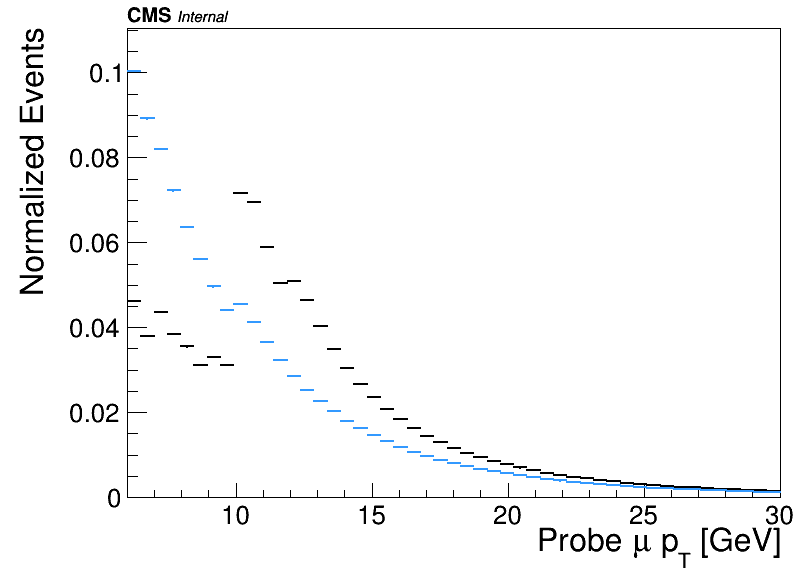

In [11]:
plot('mProbe_pt', np.linspace(start=6, stop=30, num=50), 'Probe #mu p_{T} [GeV]', logx=False, logy=False);

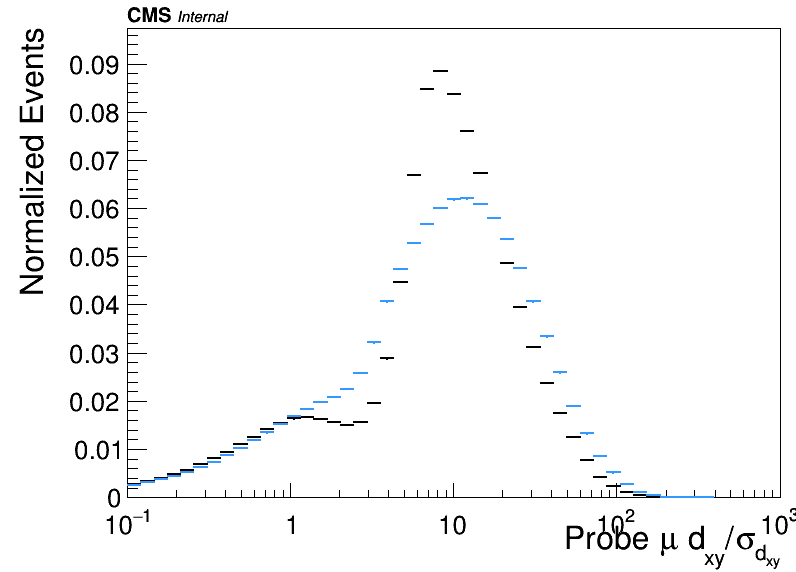

In [12]:
plot('mProbe_sigdxy', np.logspace(start=-1, stop=3, num=50), 'Probe #mu d_{xy}/#sigma_{d_{xy}}', logx=True, logy=False);

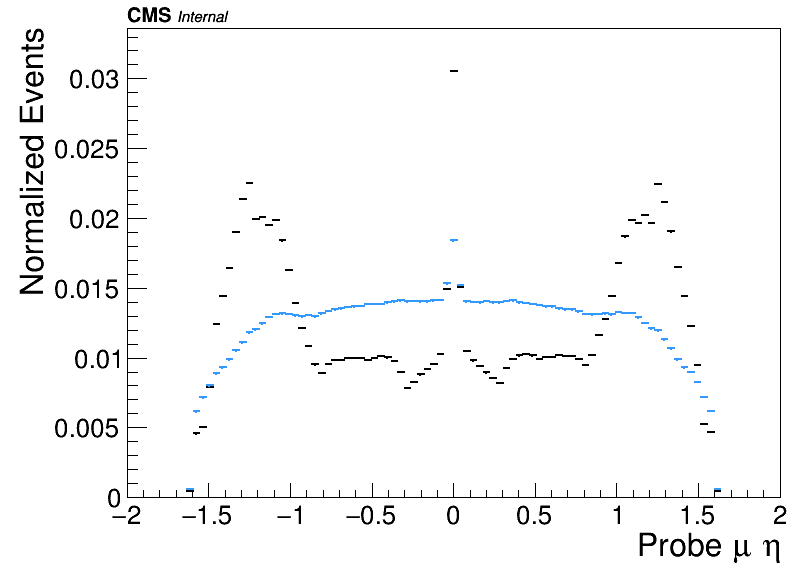

In [13]:
plot('mProbe_eta', np.linspace(start=-2, stop=2, num=100), 'Probe #mu #eta', logx=False, logy=False);

# Efficiency functions

In [14]:
def analyzeBin(idx, reloadDf=False, verbose=False):
    df = dfToUse
    print idx, 'started'
    if reloadDf:
        raise
    psCut = []
    lim = {}
    selTot = None
    st = time.time()
    for n, i in idx.iteritems():
        lim[n] = [binning[n][i], binning[n][i+1]]
        if n=='eta':
            aux = np.abs(df['mProbe_'+n])
            sel = np.logical_and(aux > lim[n][0], aux < lim[n][1])
        else:
            sel = np.logical_and(df['mProbe_'+n] > lim[n][0], df['mProbe_'+n] < lim[n][1])
        if selTot is None:
            selTot = sel
        else:
            selTot = np.logical_and(sel, selTot)
    selTot = np.logical_and(selTot, df['prescale'+probeTrigger[4:]] > 0)

    if verbose: 
        print ' --- Total ---'
    st = time.time()
    nSigTot = np.sum(selTot)
    if verbose: 
        print 'Time: {:.1f} s'.format(time.time()-st)
        print ' --- Passed ---'
    st = time.time()
    selTot = np.logical_and(selTot, df['mProbe_' + probeTrigger] == 1)
    nSigPass = np.sum(selTot)
    
    if verbose: 
        print 'Time: {:.1f} s'.format(time.time()-st)
    print idx, 'done'
    return idx, nSigTot, nSigPass

# Run the fit in each bin

In [33]:
dataset = 'RD'
if dataset == 'RD':
    CMS_lumi.extraText = "     Internal"
    dfToUse = dfRD
elif dataset == 'MC':
    CMS_lumi.extraText = "     Simulation Internal"
    dfToUse = dfMC

In [34]:
probeTrigger = 'HLT_Mu7_IP4'
binning = {'pt': array('d', [5.5, 6.5, 7, 7.1, 7.2, 7.3, 7.6, 8, 9, 12, 20]),
           'eta': array('d', [0, 0.4, 0.8, 1.5]),
           'sigdxy': array('d', [3, 4, 4.5, 5, 6, 10, 20, 200])
          }

# probeTrigger = 'HLT_Mu9_IP6'
# binning = {'pt': array('d', [8, 8.5, 9, 9.1, 9.2, 9.3, 9.6, 10, 11, 12, 20]),
#            'eta': array('d', [0, 0.4, 0.8, 1.5]),
#            'sigdxy': array('d', [3, 4.5, 6, 6.5, 7, 8, 10, 20, 200])
#           }

# probeTrigger = 'HLT_Mu12_IP6'
# binning = {'pt': array('d', [10, 11, 12, 12.1, 12.2, 12.3, 12.6, 13, 14, 16, 20, 30, 50, 80, 200]),
#            'eta': array('d', [0, 0.4, 0.8, 1.5]),
#            'sigdxy': array('d', [3, 4.5, 6, 6.5, 7, 8, 10, 20, 200])
#           }

In [35]:
h2 = {}
for var, cat in itertools.product(['N', 'Chi2'], ['tot', 'pass']):
    h2[var+cat] = rt.TH3D('h2'+var+cat, '', 
                          len(binning['pt'])-1, binning['pt'], 
                          len(binning['sigdxy'])-1, binning['sigdxy'], 
                          len(binning['eta'])-1, binning['eta'],)

In [36]:
start = time.time()
testOutput = analyzeBin({'pt': 2, 'sigdxy':2, 'eta':0}, verbose=True)
print testOutput
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

{'eta': 0, 'sigdxy': 2, 'pt': 2} started
 --- Total ---
Time: 2.5 s
 --- Passed ---
Time: 3.2 s
{'eta': 0, 'sigdxy': 2, 'pt': 2} done
({'eta': 0, 'sigdxy': 2, 'pt': 2}, 10654, 9036)
Total time: 0.2 mins


In [37]:
inputs = []
for ipt in range(len(binning['pt'])-1):
    for iip in range(len(binning['sigdxy'])-1):
        for ieta in range(len(binning['eta'])-1):
            idx = {'pt': ipt, 'sigdxy':iip, 'eta': ieta}
            inputs.append(idx)
print 'Total bins:', len(inputs)

Total bins: 210


In [38]:
multiCpu = True
if multiCpu:
    N_max = max(1, multiprocessing.cpu_count() - 6)
    N_request = min(len(inputs), N_max)
    print 'Parallelization factor:', N_request
    p = multiprocessing.Pool(N_request)
    output = p.map(analyzeBin, inputs)
else:
    output = []
    for i in inputs:
        output.append(analyzeBin(i, verbose=True))

Parallelization factor: 26
{'eta': 0, 'pt': 0, 'sigdxy': 5} started
{'eta': 0, 'pt': 0, 'sigdxy': 2} started
{'eta': 0, 'pt': 2, 'sigdxy': 1} started
{'eta': 0, 'pt': 0, 'sigdxy': 3} started
{'eta': 0, 'pt': 2, 'sigdxy': 0} started
{'eta': 0, 'pt': 1, 'sigdxy': 4} started
{'eta': 0, 'pt': 0, 'sigdxy': 1} started
{'eta': 0, 'pt': 2, 'sigdxy': 4} started
{'eta': 0, 'pt': 0, 'sigdxy': 0} started
{'eta': 0, 'pt': 1, 'sigdxy': 1} started
{'eta': 0, 'pt': 1, 'sigdxy': 2} started
{'eta': 0, 'pt': 0, 'sigdxy': 6} started
{'eta': 0, 'pt': 1, 'sigdxy': 6} started
{'eta': 0, 'pt': 1, 'sigdxy': 5} started
{'eta': 0, 'pt': 2, 'sigdxy': 3} started
{'eta': 0, 'pt': 2, 'sigdxy': 5} started
{'eta': 0, 'pt': 1, 'sigdxy': 3} started
{'eta': 0, 'pt': 2, 'sigdxy': 2} started
{'eta': 0, 'pt': 1, 'sigdxy': 0} started
{'eta': 0, 'pt': 3, 'sigdxy': 0} started
{'eta': 0, 'pt': 3, 'sigdxy': 1} started
{'eta': 0, 'pt': 3, 'sigdxy': 4} started
{'eta': 0, 'pt': 3, 'sigdxy': 3} started
{'eta': 0, 'pt': 3, 'sigdxy': 

{'eta': 0, 'pt': 5, 'sigdxy': 2} done
{'eta': 1, 'pt': 5, 'sigdxy': 2} started
{'eta': 2, 'pt': 3, 'sigdxy': 1} done
{'eta': 0, 'pt': 6, 'sigdxy': 2} done
{'eta': 0, 'pt': 5, 'sigdxy': 4} done
{'eta': 1, 'pt': 3, 'sigdxy': 6} done
{'eta': 1, 'pt': 6, 'sigdxy': 2} started
{'eta': 1, 'pt': 5, 'sigdxy': 4} started
{'eta': 0, 'pt': 7, 'sigdxy': 2} started
{'eta': 2, 'pt': 3, 'sigdxy': 6} started
{'eta': 1, 'pt': 4, 'sigdxy': 3} done
{'eta': 2, 'pt': 4, 'sigdxy': 3} started
{'eta': 0, 'pt': 6, 'sigdxy': 3} done
{'eta': 0, 'pt': 5, 'sigdxy': 5} done
{'eta': 1, 'pt': 6, 'sigdxy': 3} started
{'eta': 1, 'pt': 5, 'sigdxy': 5} started
{'eta': 1, 'pt': 3, 'sigdxy': 5} done
{'eta': 0, 'pt': 6, 'sigdxy': 4} done
{'eta': 2, 'pt': 3, 'sigdxy': 5} started
{'eta': 1, 'pt': 4, 'sigdxy': 6} done
{'eta': 0, 'pt': 6, 'sigdxy': 0} done
{'eta': 1, 'pt': 6, 'sigdxy': 4} started
{'eta': 2, 'pt': 4, 'sigdxy': 6} started
{'eta': 1, 'pt': 6, 'sigdxy': 0} started
{'eta': 1, 'pt': 4, 'sigdxy': 4} done
{'eta': 2, 'pt

{'eta': 2, 'pt': 9, 'sigdxy': 1} done
{'eta': 2, 'pt': 8, 'sigdxy': 5} done
{'eta': 2, 'pt': 9, 'sigdxy': 6} done
{'eta': 2, 'pt': 8, 'sigdxy': 6} done
{'eta': 2, 'pt': 9, 'sigdxy': 5} done


In [39]:
for idx, nSigTot, nSigPass in output:
    ip = idx['pt']+1
    ii = idx['sigdxy']+1
    ie = idx['eta']+1
    h2['Ntot'].SetBinContent(ip, ii, ie, nSigTot)
    h2['Ntot'].SetBinError(h2['Ntot'].GetBin(ip, ii, ie), np.sqrt(nSigTot))
    h2['Npass'].SetBinContent(ip, ii, ie, nSigPass)
    h2['Npass'].SetBinError(h2['Npass'].GetBin(ip, ii, ie), np.sqrt(nSigPass))

In [40]:
if not rt.TEfficiency.CheckConsistency(h2['Npass'], h2['Ntot']): raise
pEff = rt.TEfficiency(h2['Npass'], h2['Ntot'])
pEff.SetStatisticOption(rt.TEfficiency.kFCP)
pEff.SetNameTitle('eff_'+probeTrigger, 'Efficience for '+probeTrigger)

tf = rt.TFile('../data/calibration/triggerScaleFactors/{}_{}_{}.root'.format(probeTrigger, dataset, version), 'RECREATE')
pEff.Write()
for h in h2.values():
    h.Write()
tf.Close()

1 1 0.0613882563494
2 1 0.116932746212
3 1 0.451332920025
4 1 0.490914666871
5 1 0.508130397573
6 1 0.52460971379
7 1 0.54072845425
8 1 0.534051334967
9 1 0.780497168634
10 1 0.801071887842


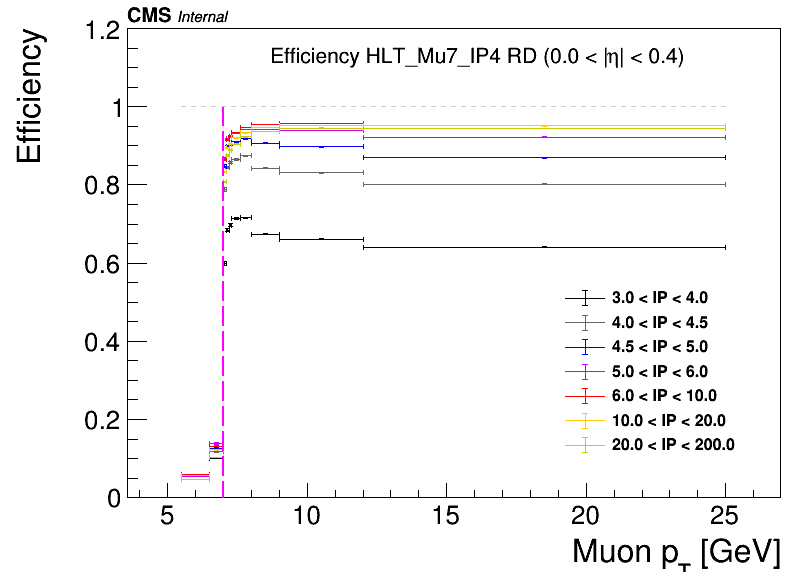

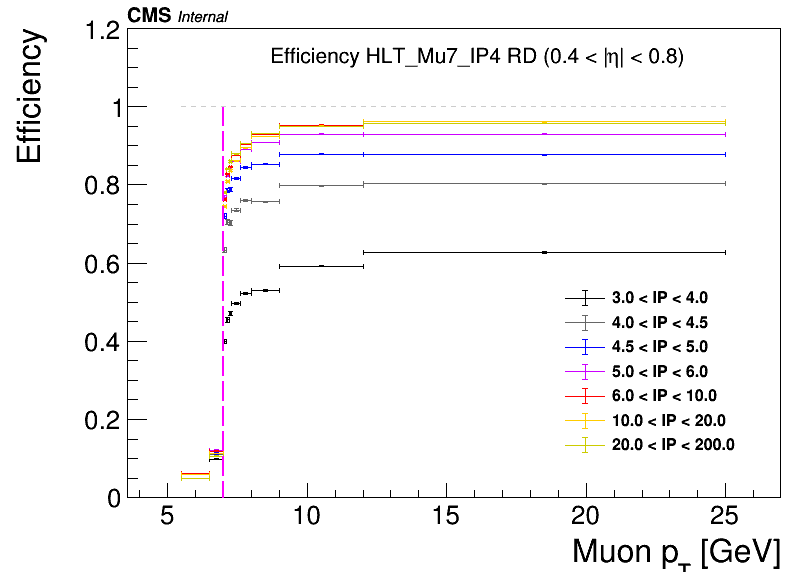

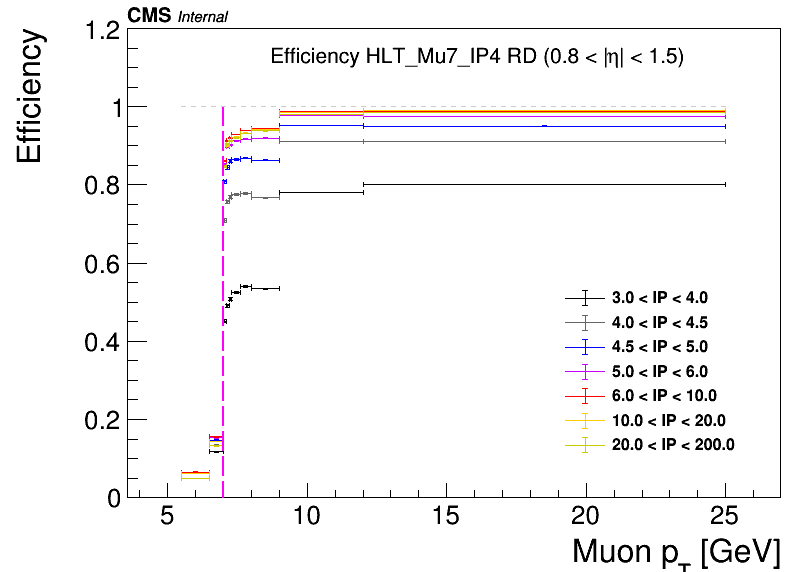

In [41]:
outCanvases = []
tdrstyle.setTDRStyle()
BRY_colors = [rt.kBlack, rt.kGray+1, 
              rt.kBlue, rt.kAzure+1,
              rt.kViolet-7, rt.kMagenta-9, rt.kRed-4, 
              rt.kOrange-3, rt.kYellow+7, rt.kGreen+1]
hRef = h2['Npass']
for iz in range(1, hRef.GetNbinsZ()+1):
    title = 'Efficiency {} {} ({:.1f} < |#eta| < {:.1f})'.format(probeTrigger, dataset, binning['eta'][iz-1], binning['eta'][iz])
    
    leg = rt.TLegend(0.7, 0.2, 0.98, 0.5)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    gr2draw = []

    for iy in range(1, hRef.GetNbinsY()+1):
        gr = rt.TGraphAsymmErrors()
        gr.SetName('gr_{}_{}'.format(iy,iz))
        for ix in range(1, hRef.GetNbinsX()+1):
            idx = pEff.GetGlobalBin(ix, iy, iz)
            if iz == 3 and iy==1:
                print ix, iy, pEff.GetEfficiency(idx)
            x = binning['pt'][ix-1] + 0.5*(binning['pt'][ix] - binning['pt'][ix-1])
            gr.SetPoint(ix-1, x, pEff.GetEfficiency(idx))
            gr.SetPointError(ix-1, x-binning['pt'][ix-1], binning['pt'][ix]-x, 
                             pEff.GetEfficiencyErrorLow(idx), pEff.GetEfficiencyErrorUp(idx)
                            )
        gr.SetLineColor(BRY_colors[iy-1])
        gr.SetMarkerColor(BRY_colors[iy-1])
        leg.AddEntry(gr, '{:.1f} < IP < {:.1f}'.format(binning['sigdxy'][iy-1], binning['sigdxy'][iy]), 'lep')
        gr2draw.append(gr)
    
    M = 1.2
    m = 0
    gr2draw[0].GetYaxis().SetRangeUser(m ,M)
    c = drawOnCMSCanvas(CMS_lumi, gr2draw, ['AP'] + (len(gr2draw)-1)*['P'], tag='_eff'+str(iz))    
    gr2draw[0].GetYaxis().SetTitle('Efficiency')
    gr2draw[0].GetXaxis().SetTitle('Muon p_{T} [GeV]')
    leg.Draw()
#     c.SetLogx()
#     c.SetLogy()
#     m = 1e-3
#     M = 5
    gr2draw[0].GetXaxis().SetTitleOffset(1.1)
    
    trgThr = float(re.search(r'_Mu[0-9]+_', probeTrigger).group(0)[3:-1])
    cl.DrawLine(trgThr, m, trgThr, 1)
    
    l = rt.TLine()
    l.SetLineWidth(1)
    l.SetLineColor(rt.kGray)
    l.SetLineStyle(7)
    l.DrawLine(binning['pt'][0], 1, binning['pt'][-1], 1)
    
    rt.TLatex()
    text = rt.TLatex()
    text.SetTextAlign(22)
    text.SetTextSize(0.04)
    text.SetTextFont(42)
    text.DrawLatexNDC(0.6, 0.9, title);

    imgLoc = '../data/calibration/triggerScaleFactors/figEff/'
    c.SaveAs(imgLoc + probeTrigger+ '_' + dataset + '_eta{}_{}.png'.format(iz-1, version))
    outCanvases.append([c, gr2draw, leg])